# Load Saved SVC

In [2]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
from lesson_functions import *

svc = None
X_train_scaler = None

with open('svm-yuv-16x2x11.p', 'rb') as f:
    data = pickle.load(f)
    print(data)
    svc = data['svm']
    X_scaler = data['scaler']
    params = data['params']

color_space = params['color_space']
color_space_code = eval('cv2.COLOR_RGB2' + params['color_space'])

def get_box_features(box_img_cs):
    if box_img_cs.shape[0] != 64 or box_img_cs.shape[1] != 64:
        raise Exception("Image has to be 64 x 64")
        
    features = single_img_features(box_img_cs,
                                spatial_size=params['spatial_size'],
                                hist_bins=params['hist_bins'], 
                                orient=params['orient'], 
                                pix_per_cell=params['pix_per_cell'], 
                                cell_per_block=params['cell_per_block'], 
                                hog_channel=params['hog_channel'],
                                spatial_feat=params['spatial_feat'], 
                                hist_feat=params['hist_feat'],
                                hog_feat=params['hog_feat'])
    
    # normalize features of the box using the same parameters as were used while training
    return X_scaler.transform([np.ravel(features)])

def get_box_pixels(img, box):
    box_img = img[box[0][1]:box[1][1], box[0][0]:box[1][0]]
    box_img_64 = cv2.resize(box_img, (64,64))    
    return box_img_64

def has_car(img_cs, box):
    box_img_64 = get_box_pixels(img_cs, box)
    features = get_box_features(box_img_64)
    return svc.predict(features)


print('SVM loaded: svc')
print('Scaler loaded: X_train_scaler')
print('Color Space: cv2.COLOR_RGB2' + color_space)

{'scaler': StandardScaler(copy=True, with_mean=True, with_std=True), 'params': {'hog_feat': True, 'hist_bins': 32, 'cell_per_block': 2, 'pix_per_cell': 16, 'hist_feat': True, 'spatial_size': (32, 32), 'C': 1, 'kernel': 'linear', 'spatial_feat': True, 'orient': 11, 'color_space': 'YUV', 'hog_channel': 'ALL'}, 'svm': LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)}
SVM loaded: svc
Scaler loaded: X_train_scaler
Color Space: cv2.COLOR_RGB2YUV


## Different Sliding Window Sizes

Testing on 1 files


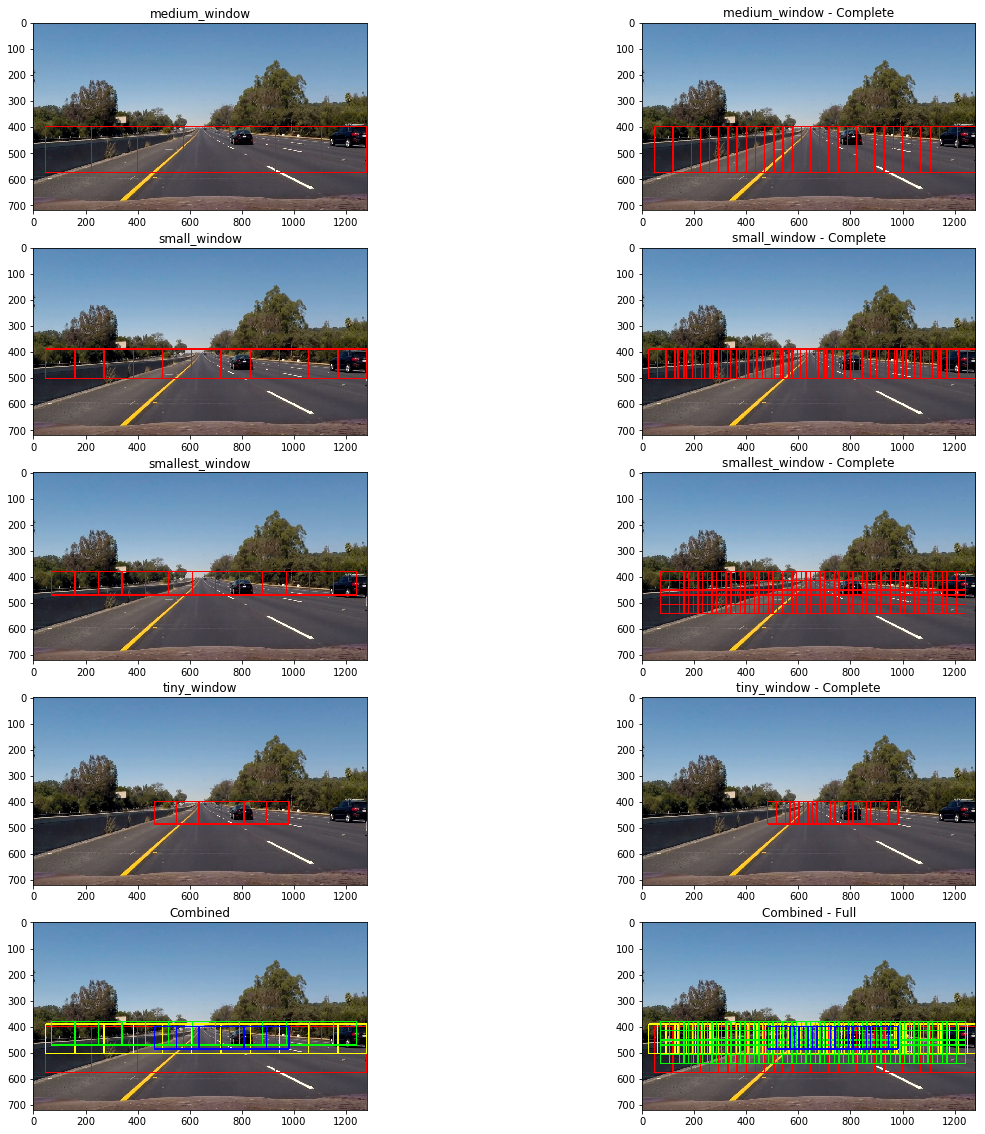

16
35
93
13


In [7]:
from windows import *

def draw_window_of_type(img, windowes, ax, title, color = (255, 0, 0)):
    img = np.copy(img)
    for window in windowes:
        cv2.rectangle(img, window[0], window[1], color, 4)
    ax.set_title(title)
    ax.imshow(img)
    return img

def draw_window_ax(img, windowes_combined, ax, title):
    img = np.copy(img)
    for windowes, color in windowes_combined:
        for window in windowes:
            cv2.rectangle(img, window[0], window[1], color, 4)
    ax.set_title(title)
    ax.imshow(img)
    return img

def show_window_sizes(filename, loaders):
    test_image = load_image(filename, 'RGB')
    
    f, ax = plt.subplots(len(loaders) + 1, 2, figsize=(20,20))
    
    colors = [(255, 0, 0), (255, 255, 0), (0,255,0), (0,0,255), (0,255,255)]
    single_windowes = []
    full_windowes = []
    
    for i, loader in enumerate(loaders):
        windowes = loader(test_image, offset = (-1,0))
        single_windowes.append((windowes, colors[i]))
        
        draw_window_of_type(test_image, windowes, ax[i,0], str(loader).split(' ')[1])

        windowes = loader(test_image)
        full_windowes.append((windowes, colors[i]))
        
        draw_window_of_type(test_image, windowes, ax[i,1], str(loader).split(' ')[1] + ' - Complete')

    single_window_img = draw_window_ax(test_image, single_windowes, ax[len(loaders), 0], 'Combined')
    single_window_img_bgr = cv2.cvtColor(single_window_img, cv2.COLOR_RGB2BGR)
    cv2.imwrite('./baykar/single_window.jpeg', single_window_img_bgr)

    test_image = draw_window_ax(test_image, full_windowes, ax[len(loaders), 1], 'Combined - Full')
    
    test_image_bgr = cv2.cvtColor(test_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite('./baykar/test_image.jpeg', test_image_bgr)
    
        
#test_images = glob.glob('./test_images/*.jpg')
test_images = ['./test_images/1259.jpg']
print('Testing on {} files'.format(len(test_images)))

for filename in test_images:
    show_window_sizes(filename, [medium_window, small_window, smallest_window, tiny_window])

plt.show()
plt.close('all')

img_cs = load_image('./test_images/1259.jpg', params['color_space'])

print(len(medium_window(img_cs)))
print(len(small_window(img_cs)))
print(len(smallest_window(img_cs)))
print(len(tiny_window(img_cs)))

C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


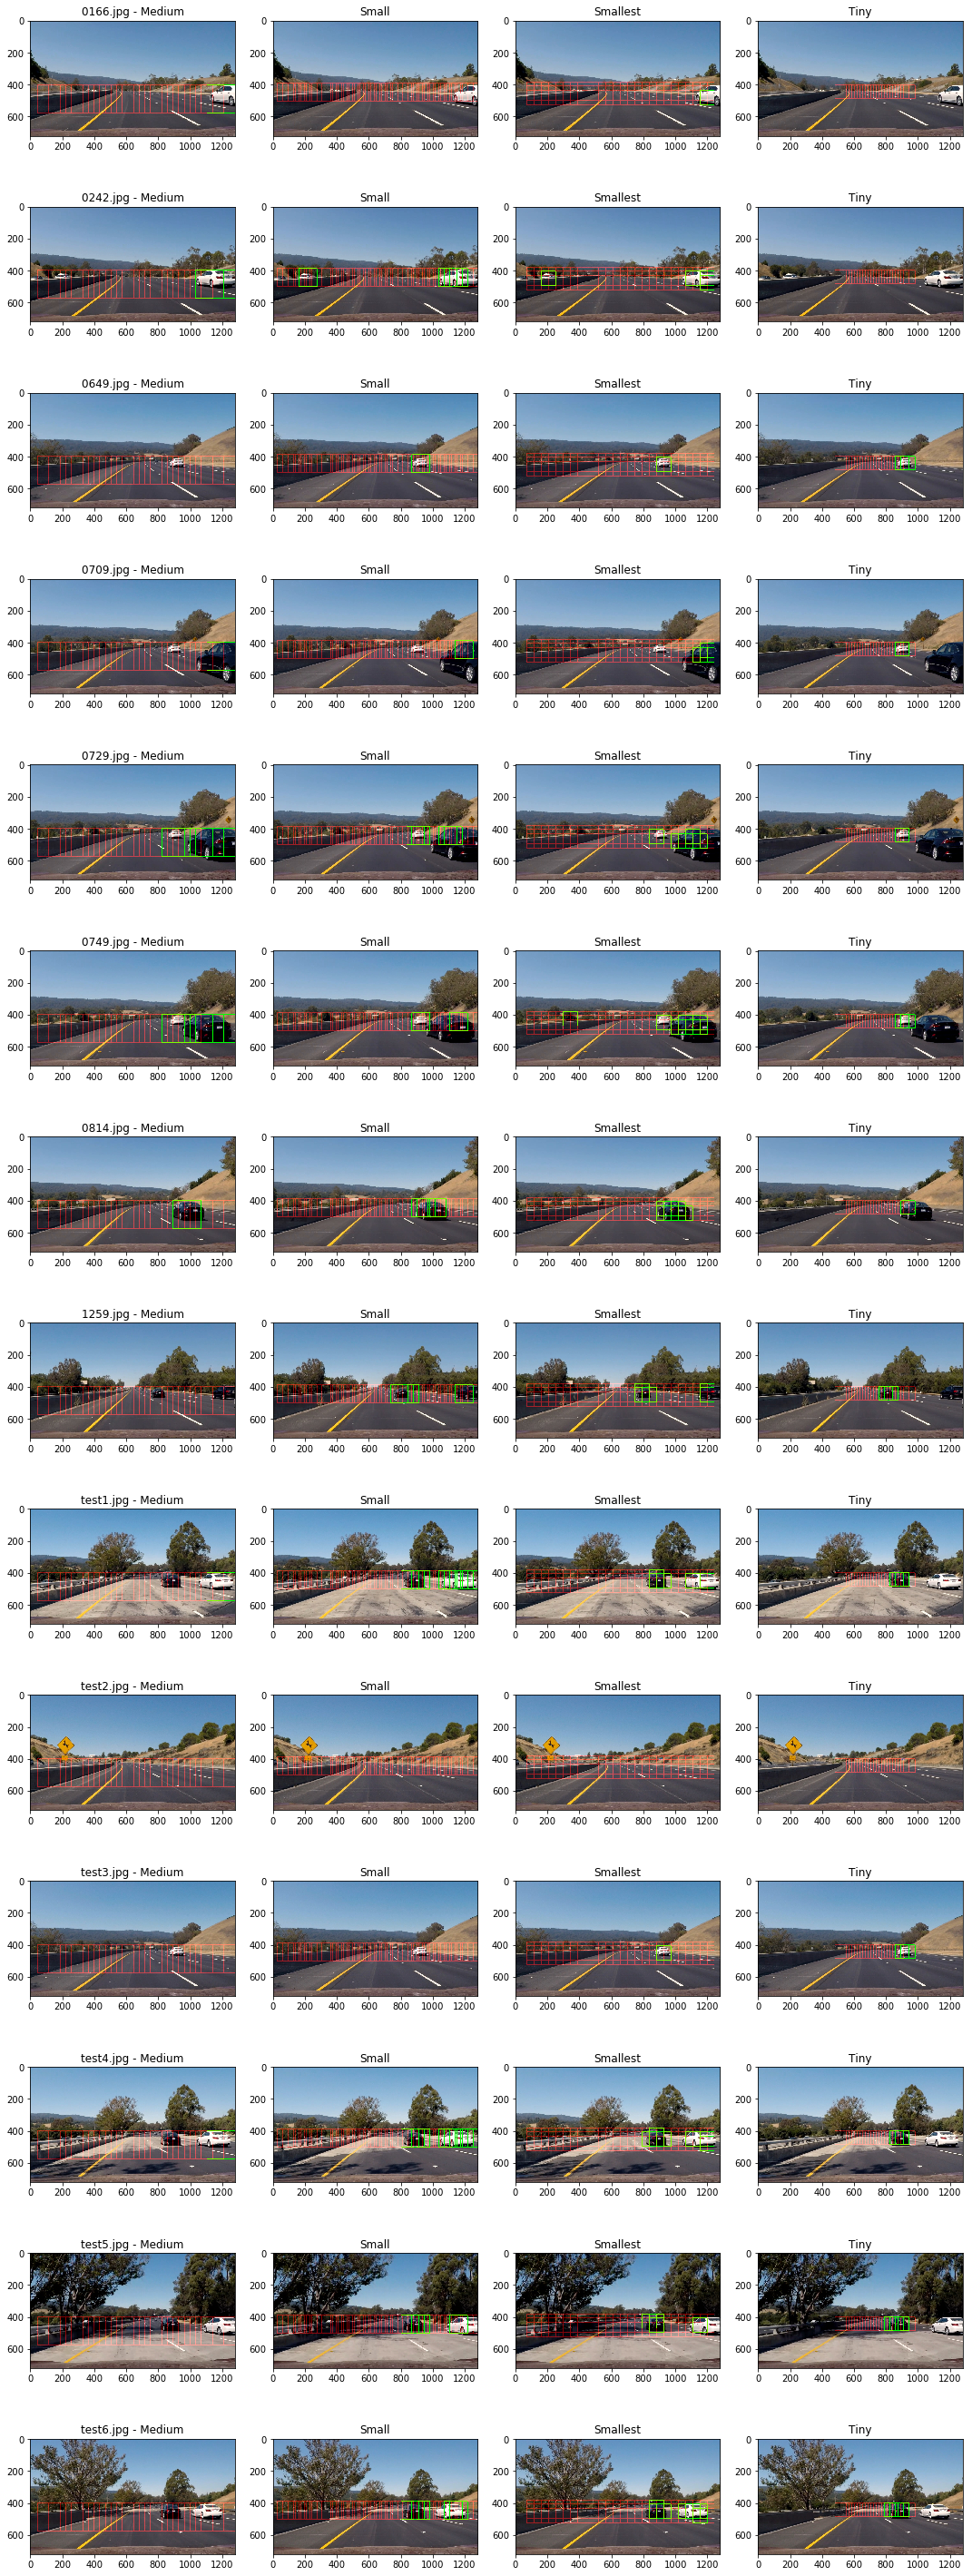

In [18]:
import os

def show_different_boxes(row_no, filename, ax):
    img = load_image(filename, 'RGB')
    basename = os.path.basename(filename)
    
    #show_boxes_with_car(img, big_box(img), 'Big', ax[0])
    show_boxes_with_car(img, medium_window(img), '{} - Medium'.format(basename), ax[row_no,0])
    show_boxes_with_car(img, small_window(img), 'Small', ax[row_no,1])
    show_boxes_with_car(img, smallest_window(img, offset=(-0.5,0.3)), 'Smallest', ax[row_no,2])
    show_boxes_with_car(img, tiny_window(img), 'Tiny', ax[row_no,3])

def show_boxes_with_car(img, boxes, title, ax):
    img_cs = cv2.cvtColor(img, color_space_code)
    canvas = np.copy(img)
    canvas2 = np.zeros_like(img)
    
    for box in boxes:
        if has_car(img_cs, box):
            cv2.rectangle(canvas, box[0], box[1], (0,255,0), 4)
        else:
            cv2.rectangle(canvas2, box[0], box[1], (255,0,0), 4)

    canvas = cv2.addWeighted(canvas, 1, canvas2, 0.5, 0)
    ax.imshow(canvas)
    ax.set_title(title)
    

#test_images = ['./test_images/0649.jpg']
test_images = glob.glob('./test_images/*.jpg')
f, ax = plt.subplots(len(test_images), 4, figsize=(15,40))
f.tight_layout()

for row_no, filename in enumerate(test_images):
#     f, ax = plt.subplots(1, 4, figsize=(15,40))
#     f.tight_layout()
    show_different_boxes(row_no, filename, ax)


plt.show()
plt.close('all')

# Heatmap

In [12]:
import glob
from scipy.ndimage.measurements import label

def detect_cars(img, all_boxes = False):
    img_cs = cv2.cvtColor(img, color_space_code)
    
    boxes = get_all_windows(img_cs)
    car_boxes = []
    notcar_boxes = []
    
    for box in boxes:
        if has_car(img_cs, box):
            car_boxes.append(box)
        else:
            notcar_boxes.append(box)
            
    if not all_boxes:
        return car_boxes
    else:
        return car_boxes, notcar_boxes

def heatmap_threshold(heatmap, threshold):
    heatmap[heatmap < threshold] =  0
    
def add_heat(heatmap, boxes):
    for box in boxes:
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    
def draw_labeled_bboxes(img, labels):
    colors = [(255,0,0), (0,255,0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
              (255, 0, 255), (255, 150, 0), (255, 0, 150), (150, 75, 0), (150, 0, 75)]

    labels_img = np.zeros_like(img)
    
    # add more colors to the array in case there are more labels than number of defined colors
    if labels[1] == len(colors):
        extra = labels[1] - len(colors)
        colors.extend([(255,0,0)] * extra)
    
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        mask = labels[0] == car_number
        labels_img[mask] = colors[car_number - 1]
        
        nonzero = (mask).nonzero()
        
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))

        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    return labels_img

def get_heat_img(img, heatmap):
    hot_colors = [(0,0,0), (90,0,0), (212,0,0), (255, 63, 0), (255,103,0), (255,225,0), (255,225,0), (255,225,0)]

    heatmap = np.clip(heatmap, 0, 255)
    max_heat = np.max(heatmap)
    print(max_heat)
    
    if max_heat >= len(hot_colors):
        # only change those colors which are > 0 
        mask = heatmap > 0
        cap = len(hot_colors) - 1
        heatmap[mask] = (heatmap[mask] / max_heat * cap + 1)
    
    heat_img = np.zeros(shape=(heatmap.shape[0], heatmap.shape[1], 3)).astype(np.uint8)
    
    for index in range(0, len(hot_colors)):
        mask = (heatmap > index) & (heatmap <= index + 1)
        locations = np.where(mask)
        heat_img[locations[0], locations[1]] = hot_colors[index]
    
    return cv2.addWeighted(img, 0.4, heat_img, 0.6, 0)

def draw_car_notcar(img, car_boxes, boxes):
    for box in notcar_boxes:
        cv2.rectangle(img, box[0], box[1], (255,0,0), 4)
    for box in car_boxes:
        cv2.rectangle(img, box[0], box[1], (0,255,0), 6)

## Heatmap Test

1.0


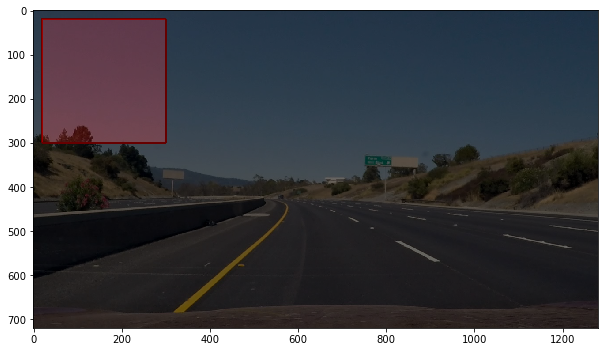

In [13]:
def get_heat_img(img, heatmap):
    hot_colors = [(0,0,0), (90,0,0), (212,0,0), (255, 63, 0), (255,103,0), (255,225,0), (255,225,0), (255,225,0)]

    heatmap = np.clip(heatmap, 0, 255)
    max_heat = np.max(heatmap)
    print(max_heat)

    cap = len(hot_colors) - 1

    if max_heat >= cap:
        # only change those colors which are > 0 
        mask = heatmap > 0
        heatmap[mask] = (heatmap[mask] / max_heat * cap + 1)
    
    heat_img = np.zeros(shape=(heatmap.shape[0], heatmap.shape[1], 3)).astype(np.uint8)
    
    for index in range(0, cap):
        mask = (heatmap > index) & (heatmap <= index + 1)
        locations = np.where(mask)

        if locations[0].shape[0] > 0:
            heat_img[locations[0], locations[1]] = hot_colors[index + 1]
            #print('Setting locations: ', locations[0].shape, ' with color ', hot_colors[index + 1])
    
    return cv2.addWeighted(img, 0.4, heat_img, 0.6, 0)

car_boxes = [((20,20), (300,300))]
filename = './project_video-frames/0000.jpg'
img = load_image(filename, 'RGB')

heatmap = np.zeros(img.shape[:2], np.float32)
add_heat(heatmap, car_boxes)

for box in car_boxes:
    cv2.rectangle(img, box[0], box[1], (255, 0, 0), 4)

heat_img = get_heat_img(img, heatmap)

f, ax = plt.subplots(1, 1,figsize=(10,5))
f.tight_layout()
ax.imshow(heat_img)
plt.show()


Testing on 1 files


C:\Users\fahad\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


[((1104, 400), (1280, 576)), ((1033, 400), (1209, 576)), ((963, 400), (1139, 576)), ((1067, 390), (1179, 502)), ((1078, 416), (1168, 506)), ((1042, 416), (1132, 506)), ((1150, 452), (1240, 542)), ((1114, 452), (1204, 542))]
7.0


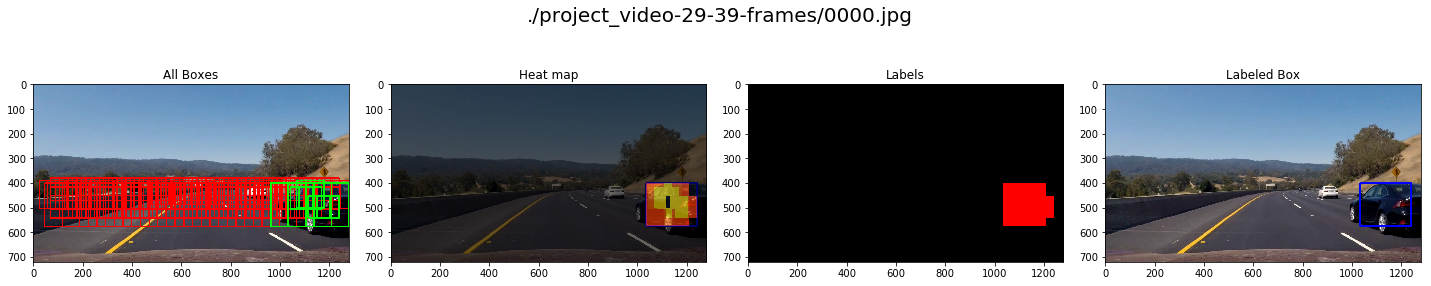

In [14]:
#test_images = glob.glob('./test_images/*.jpg')
test_images = ['./project_video-29-39-frames/0000.jpg']
print('Testing on {} files'.format(len(test_images)))

for filename in test_images:
    img = load_image(filename, 'RGB')

    heatmap = np.zeros(img.shape[:2], np.float32)
    
    car_boxes, notcar_boxes = detect_cars(img, True)
    print(car_boxes)
    
    img_boxes = np.copy(img)
    draw_car_notcar(img_boxes, car_boxes, notcar_boxes)
    
    add_heat(heatmap, car_boxes)
    heatmap_threshold(heatmap, 2)
    labels = label(heatmap)
    labels_img = draw_labeled_bboxes(img, labels)

    heat_img = get_heat_img(img, heatmap)
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,5))
    f.tight_layout()
    f.suptitle(filename, fontsize=20)
    ax1.imshow(img_boxes)
    ax1.set_title('All Boxes')
    ax2.imshow(heat_img)
    ax2.set_title('Heat map')
    ax3.imshow(labels_img)
    ax3.set_title('Labels')
    ax4.imshow(img)
    ax4.set_title('Labeled Box')
    
plt.show()
plt.close('all')


## False Positive

In [ ]:
import os
import threading
import time

class CarDetector(threading.Thread):
    def __init__(self, img_cs, boxes, global_box_no):
        threading.Thread.__init__(self)
        self.boxes = boxes
        self.img_cs = img_cs
        self.car_boxes = []
        self.car_box_nos = []
        self.global_box_no = global_box_no
        
    def run(self):
        for box_no, box in enumerate(self.boxes):
            if has_car(self.img_cs, box):
                self.car_boxes.append(box)
                self.car_box_nos.append(self.global_box_no + box_no)

class ProblemBox:
    def __init__(self, filename, loader = smallest_box):
        self.filename = filename
        self.img = load_image(filename, 'RGB')
        self.img_cs = cv2.cvtColor(self.img, color_space_code)
        self.boxes = loader(self.img)
        
    def show_specific_box(self, box_no, color=(255,0,0)):
        img_copy = np.copy(self.img)

        box = self.boxes[box_no]
        cv2.rectangle(img_copy, box[0], box[1], color, 4)

        box_img = get_box_pixels(self.img, box)
        box_img_cs = get_box_pixels(self.img_cs, box)
        color_features = color_hist(box_img_cs)
        
        _, hog_img_l = get_hog_features(box_img_cs[:,:,0], 
                                orient = orient, 
                                pix_per_cell = pix_per_cell, 
                                cell_per_block = cell_per_block, 
                                vis=True, 
                                feature_vec=True)
        
        f, (ax1, ax2, ax3, ax4) = plt.subplots(1,4,figsize=(10,5))
        ax1.imshow(img_copy)
        ax1.set_title('Car Detected')
        ax2.imshow(box_img)
        ax2.set_title('Window #:{}'.format(box_no))
        ax3.plot(color_features)
        ax3.set_title('Color Histogram')
        ax4.imshow(hog_img_l, cmap='gray')
        ax4.set_title("HOG of L")
        
        return box_img
            

    def get_box_filename(self, box_no):
        basename = os.path.basename(self.filename)
        file_no_ext = os.path.splitext(basename)[0]
        return './problem/{}-{}.jpg'.format(file_no_ext, box_no)

    def save_box(self, box_no):
        output = self.get_box_filename(box_no)
        box = self.boxes[box_no]
        box_img = get_box_pixels(self.img, box)
        box_img_bgr = cv2.cvtColor(box_img, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output, box_img_bgr)
        print(output)

    def show_box_nos(self, box_nos):
        for box_no in box_nos:
            self.show_specific_box(box_no)

    def show_all_cars_threaded(self, img, close_up = False, save = False):
        threads = []
        per_thread = len(self.boxes) // 20
        for i in range(0, len(self.boxes), per_thread):
            
            if i + per_thread < len(self.boxes):
                #print(i,i + per_thread)
                box_range = self.boxes[i:i + per_thread]
            else:
                #print(i,' Till End')
                box_range = self.boxes[i:]
            
            threads.append(CarDetector(self.img_cs, box_range, i))

        for thread in threads:
            thread.start()

        for thread in threads:
            thread.join()
            
            for i, box in enumerate(thread.car_boxes):
                cv2.rectangle(img, box[0], box[1], (255, 0, 0), 4)
                
                if close_up:
                    self.show_specific_box(thread.car_box_nos[i], color=(0,255,0))

                if save:
                    self.save_box(thread.car_box_nos[i])

    def show_all_cars_threaded_bg(self, img, close_up = False, save = False):
        for thread in bg_threads:
            thread.work(self.img_cs)

        for thread in bg_threads:
            thread.done.wait()
            
            for i, box in enumerate(thread.car_boxes):
                cv2.rectangle(img, box[0], box[1], (255, 0, 0), 4)
                
                if close_up:
                    self.show_specific_box(thread.car_box_nos[i], color=(0,255,0))

                if save:
                    self.save_box(thread.car_box_nos[i])
        
    def show_all_cars(self, img, close_up = False, save = False):
        for box_no, box in enumerate(self.boxes):
            if has_car(self.img_cs, box):
                cv2.rectangle(img, box[0], box[1], (255, 0, 0), 4)
                #print('Found car at box', box, box_no)
                
                if close_up:
                    self.show_specific_box(box_no, color=(0,255,0))

                if save:
                    self.save_box(box_no)

#test_images = glob.glob('./project_video-frames/0009.jpg')
# for filename in test_images:
#     pb = ProblemBox(filename, get_all_boxes)
#     img = np.copy(pb.img)
    
#     t1 = time.time()
#     pb.show_all_cars(img, save = False)
#     t2 = time.time()
#     print('Non-Threaded Time taken:', t2 - t1)

#     plt.imshow(img)
#     plt.show()
    

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(15,5))

#for filename in test_images:
for frame_no in range(649,650):
    filename =  './project_video-frames/{:04d}.jpg'.format(frame_no)
    pb = ProblemBox(filename, get_all_boxes)
    
    img = np.copy(pb.img)
    t1 = time.time()
    pb.show_all_cars_threaded(img, save = False)
    t2 = time.time()
    print('Threaded - Time taken:', t2 - t1)

    ax1.imshow(img)
    ax1.set_title(filename + "threaded")

    img = np.copy(pb.img)
    t1 = time.time()
    pb.show_all_cars_threaded_bg(img, save = False)
    t2 = time.time()
    print('Threaded BG - Time taken:', t2 - t1)
    ax2.imshow(img)
    ax2.set_title(filename + "threaded bg")

    img = np.copy(pb.img)
    t1 = time.time()
    pb.show_all_cars(img, save = False)
    t2 = time.time()
    print('Non-Threaded Time taken:', t2 - t1)

    ax3.imshow(img)
    ax3.set_title(filename)

    plt.show()
    
plt.show()
plt.close('all')

In [ ]:
import threading
import time

class CarDetectorThread(threading.Thread):
    def __init__(self, boxes, global_box_no):
        threading.Thread.__init__(self)
        self.boxes = boxes
        self.img_cs = None
        self.car_boxes = []
        self.car_box_nos = []
        self.global_box_no = global_box_no
        self.cv = threading.Condition()
        self.death = False
        self.done = threading.Event()
        
    def run(self):
        while not self.death:
            self.cv.acquire()
            self.cv.wait()
            if self.death:
                break

            for box_no, box in enumerate(self.boxes):
                if has_car(self.img_cs, box):
                    self.car_boxes.append(box)
                    self.car_box_nos.append(self.global_box_no + box_no)
            
            self.done.set()

    def work(self, img_cs):
        self.car_boxes = []
        self.car_box_nos = []
        self.done.clear()
        self.img_cs = img_cs
        self.cv.acquire()
        self.cv.notify_all()
        self.cv.release()

def kill_threads():
    if len(bg_threads) > 0:
        print('Threads already exist, killing them...')
        for thread in bg_threads:
            thread.death = True
            thread.work(None)

        for thread in bg_threads:
            thread.join(5)
            if thread.is_alive():
                print('Ops thread did not stop')
        
        print('All threads killed')
        bg_threads = []
    else:
        print('No thread found')

try:
    bg_threads
    kill_threads()
except NameError:
    print('defining bg_threads')
    bg_threads = []

def create_threads(img):
    boxes = get_all_boxes(img)
    per_thread = len(boxes) // 20

    for i in range(0, len(boxes), per_thread):
        if i + per_thread < len(boxes):
            #print(i,i + per_thread)
            box_range = boxes[i:i + per_thread]
        else:
            #print(i,' Till End')
            box_range = boxes[i:]

        bg_threads.append(CarDetectorThread(box_range, i))

    for thread in bg_threads:
        print('Starting thread (Box Start): ', thread.global_box_no)
        thread.start()
    
test_images = glob.glob('./project_video-frames/0000.jpg')
img = load_image(test_images[0], color_space)
create_threads(img)

In [ ]:
from collections import deque

def get_center(box):
    width = box[1][0] - box[0][0]
    height = box[1][1] - box[0][1]
    return np.int_([box[0][0] + width // 2, box[0][1] + height // 2])

def debug(str, *args):
    #print(str, args)
    pass


class Vehicle():
    def __init__(self, car_no):
        self.bounding_box = None
        self.last_bounding_box = None
        self.speed = 0.0
        self.center = None
        self.car_no = car_no
        self.alpha = 0.5
        self.center_alpha = 0.7
        self.frame_count = 0
        self.bound_pixels = 20
        self.speed = 0

    def get_w_h(self, box):
        width = box[1][0] - box[0][0]
        height = box[1][1] - box[0][1]
        return width, height
    
    def might_go_out(self):
        # in case the car is towards the bottom of the screen and is not a new car
        return self.frame_count > 3 and self.center[1] >= 650 
    
    def is_within_bounds(self, center):
        # get the sum of square difference between 2 centers and see if it is 
        # within bounds then yes, otherwise no
        return np.sqrt(np.sum((self.center - center) ** 2)) <= self.bound_pixels
        
    def update_box(self, box):
        self.frame_count += 1
        width, height = self.get_w_h(box)
        
        if self.center is None:
            self.bounding_box = box
            self.center = get_center(box)
        else:
            self.last_bounding_box = self.bounding_box

            # increase / decrease slowly
            old_width, old_height = self.get_w_h(self.last_bounding_box)
            
            new_width = old_width * (1 - self.alpha) + width * self.alpha
            new_height = old_height * (1 - self.alpha) + height * self.alpha

            debug('Last bbox', self.last_bounding_box, 'New Box:', box)
            debug('Old W,h', old_width, old_height, 'New Width Height', new_width, new_height)

            center = get_center(box)
            debug('Center given', center)
            
            last_center = self.center
            self.center = self.center * (1 - self.center_alpha) + center * self.center_alpha
            
            self.bounding_box = (int(self.center[0] - new_width // 2), int(center[1] - new_height // 2)), \
                                (int(center[0] + new_width // 2), int(center[1] + new_height // 2))
        
            delta = self.center - last_center
            self.speed += delta
            
            debug('Filtered center', self.center)
            debug('Final BBox', self.bounding_box)
            
class VehicleIdentifier():
    def __init__(self):
        self.min_frames = 10
        self.threshold = 10
        self.heatmaps = deque(maxlen = self.min_frames)
        self.cars = []
        
    def get_bounding_box(self, labels, car_no):
        mask = labels[0] == car_no

        nonzero = (mask).nonzero()

        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        return bbox

    def get_car_for_bbox(self, bbox):
        car = None
        center = get_center(bbox)
        
        for c in self.cars:
            if c.is_within_bounds(center):
                car = c
                break
                
        return car
    
    def color_labels(self, img, labels):
        colors = [(255,0,0), (0,255,0), (0, 0, 255), (255, 255, 0), (0, 255, 255),
                  (255, 0, 255), (255, 150, 0), (255, 0, 150), (150, 75, 0), (150, 0, 75)]

        labels_img = np.zeros_like(img)

        # add more colors to the array in case there are more labels than number of defined colors
        if labels[1] == len(colors):
            extra = labels[1] - len(colors)
            colors.extend([(255,0,0)] * extra)

        # Iterate through all detected cars
        for car_number in range(1, labels[1]+1):
            mask = labels[0] == car_number
            labels_img[mask] = colors[car_number - 1]

        return labels_img

    def draw_cars(self, output_img):
        for car in self.cars:
            cv2.rectangle(output_img, car.bounding_box[0], car.bounding_box[1], (0,255,0), 6)
        
    def process_image(self, img):
        debug('Processing image, len(car)', len(self.cars))
        
        #print(color_space_code)
        boxes = detect_cars(img)
        #print(boxes)
        heatmap = np.zeros(img.shape[:2], np.float)
        add_heat(heatmap, boxes)
        self.heatmaps.append(heatmap)

        heat_img = get_heat_img(img, heatmap)
        output_img = np.copy(img)
        
        # draw boxes found in this frame on the image
        img_tl = np.copy(img)
        for box in boxes:
            cv2.rectangle(img_tl, box[0], box[1], (0,255,0), 4)
        output_img[0:180,0:320] = cv2.resize(img_tl, (320, 180))
        
        # draw this frame's heatmap on the top center of the image
        output_img[0:180,320:640] = cv2.resize(heat_img, (320, 180))

        if len(self.heatmaps) >= self.min_frames:
            debug('Heatmap can be summed')
            summed_up = np.sum(self.heatmaps, axis=0)
            heatmap_threshold(summed_up, self.threshold)
            
            cars_seen = [False] * len(self.cars)
            
            labels = label(summed_up)
            for car_no in range(1, labels[1]+1):
                debug('Label says car #:', car_no)
                car_box = self.get_bounding_box(labels, car_no)
                car = self.get_car_for_bbox(car_box)
                
                if car is None:
                    debug('We have never seen this car # before. box:', car_box)
                    car = Vehicle(car_no)
                    self.cars.append(car)
                else:
                    debug('Have seen this car before, it is car #', car.car_no)
                    cars_seen[car.car_no - 1] = True
                
                car.update_box(car_box)
                
            # is there a car that we did not see this time? if yes, maybe
            # it could have been overlapping
            for i in range(len(cars_seen)):
                if cars_seen[i] == False:
                    car = self.cars[i]
                    debug('did not see car #', car.car_no, 'speed:', car.speed)
            
            
            #labels_img = draw_labeled_bboxes(output_img, labels)
            labels_img = self.color_labels(output_img, labels)
            self.draw_cars(output_img)

            heat_img = get_heat_img(img, summed_up)
            output_img[0:180,640:960] = cv2.resize(heat_img, (320, 180))
            output_img[0:180,960:1280] = cv2.resize(labels_img, (320,180))

        return output_img

identifier = VehicleIdentifier()

# box = ((300,50), (400,150))

# car = Vehicle(3)
# car.update_box(box)

# box = (box[0][0], box[0][1] - 50), (box[1][0], box[1][1] - 10)

# center = get_center(box)
# print(car.is_within_bounds(center))

In [ ]:
# for frame_no in range(0, 10):
#     filename = './project_video-29-39-frames/{:04d}.jpg'.format(frame_no)
#     print(filename)
#     # read RGB since thats what video will give us and then our function
#     # internally converts it to LAB
#     img = load_image(filename, 'RGB')
#     output_img = identifier.process_image(img)
    
#     #output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
#     #cv2.imwrite('./frame-cars/{:04d}.jpg'.format(frame_no), output_img)
    
#     print('Frame:', frame_no)
#     plt.imshow(output_img)
#     plt.show()

In [ ]:
# frame_no = 12

# filename = './project_video-29-39-frames/{:04d}.jpg'.format(frame_no)
# # read RGB since thats what video will give us and then our function
# # internally converts it to LAB
# img = load_image(filename, 'RGB')
# print(img.shape)
# plt.imshow(img)

# output_img = identifier.process_image(img)

# # output_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# # cv2.imwrite('./frame-cars/{:04d}.jpg'.format(frame_no), output_img)

# print('Frame:', frame_no)
# f, ax = plt.subplots(1,1,figsize=(20,10))
# ax.imshow(output_img)
# plt.show()

In [ ]:
from moviepy.editor import VideoFileClip

identifier = VehicleIdentifier()
print(identifier.heatmaps)

video_filename = 'project_video.mp4'
clip = VideoFileClip(video_filename)

video_with_cars = clip.fl_image(identifier.process_image)

output = os.path.splitext(video_filename)
output_file = output[0] + "-cars" + output[1]

video_with_cars.write_videofile(output_file, audio=False)

print('File saved to:', output_file)

In [ ]:
# from moviepy.editor import VideoFileClip
# clip = VideoFileClip("project_video.mp4").subclip(29, 39)
# clip.write_videofile('project_video-29-39.mp4', audio=False)
from moviepy.editor import VideoFileClip

video_filename = 'project_video.mp4'
clip = VideoFileClip(video_filename)
print(clip.fps)